# Analysis of Cosmetic Product Demand (Simulated Dataset In Tehran)

##  Objective
The goal of this notebook is to Identify Neighborhood-Level Trends in Cosmetic Product Demand
## focuse on:
- Calculate requests in nighborhoood
- Analyzing holiday effects on demand trends
- Detecting monthly request dynamics
- Computing monthly demand trends
- Classifying neighborhoods based on demand growth and volatility 
## Input
- Simulated CSV Dataset of cosmetic product demand in neighborhoods
- json file of tehan neighborhoods

## Output
- Spatial Distribution Map of Cosmetic Product Demand.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import jdatetime

In [2]:
df= pd.read_csv(r"./customers_sample.csv")

In [3]:
gdf= gpd.read_file(r"./neighborhoods.json")

# Formatting and parsing date field

In [4]:
df["date"]=pd.to_datetime(df["date_"].astype(str))

In [5]:
def gre_to_jalali(gregorian_date):
    if pd.isnull(gregorian_date):
        return None
    return jdatetime.datetime.fromgregorian(date=gregorian_date).strftime('%Y-%m-%d')

In [6]:
df["jalali_date"]=df["date"].apply(gre_to_jalali)

In [7]:
df[["jalali_year","jalali_month","jalali_day"]] = df["jalali_date"].str.split('-', expand=True)

# Mapping campaign and non-campaign days for all requests

In [8]:
campaigns = [
    {"start": "1403-11-16", "end": "1403-11-16", "type": "romantic"},
    {"start": "1403-12-01", "end": "1403-12-29", "type": "esfand_sale"},
    {"start": "1404-02-31", "end": "1404-03-10", "type": "cancer_awareness"},
    {"start": "1404-03-19", "end": "1404-03-25", "type": "end_of_month"},
    {"start": "1404-03-21", "end": "1404-04-06", "type": "birthday_10"},
]
df["campaign_flag"] = 0
df["campaign_type"] = "none"
for camp in campaigns:
    mask= ((df["jalali_date"]>=camp["start"]) & (df["jalali_date"]<=camp["end"]))
    df.loc[mask,"campaign_flag"]=1
    df.loc[mask,"campaign_type"]=camp["type"]
df.loc[df["jalali_day"].astype(int)<=5,["campaign_flag","campaign_type"]]=(1,"monthly")

# Campaigns Impact on Requests

In [9]:
import numpy as np

df_grouped = df.groupby(["neighborhood2", "campaign_flag"]).agg(
    total_requests=("id", "count"),
    total_days=("jalali_date", pd.Series.nunique)
).reset_index()


pivoted = df_grouped.pivot(
    index="neighborhood2",
    columns="campaign_flag",
    values=["total_requests", "total_days"]
    
)


pivoted.columns = ['req_non_camp', 'req_camp', 'days_non_camp', 'days_camp']


pivoted['avg_camp'] = pivoted['req_camp'] / pivoted['days_camp'].replace(0, np.nan)
pivoted['avg_non_camp'] = pivoted['req_non_camp'] / pivoted['days_non_camp'].replace(0, np.nan)
pivoted['lift'] = pivoted['avg_camp'] / pivoted['avg_non_camp']

pivoted = pivoted.dropna(subset=["avg_camp", "avg_non_camp", "lift"])

In [10]:
df=df.merge(pivoted,on="neighborhood2")

In [11]:
diff = pivoted["avg_camp"] - pivoted["avg_non_camp"]
cohen_d = diff.mean() / diff.std()
mean_lift = 100 * diff.mean() 
print(f"Cohen's d: {cohen_d:.2f}")
print(f"Mean lift: {mean_lift:.1f}%")

Cohen's d: 0.57
Mean lift: 17.4%


# Computing monthly demand trends

In [12]:
df["new_month"]=df["jalali_year"]+df["jalali_month"]
df["new_month"].astype(int)

monthly = df.groupby(['neighborhood2','new_month']).agg(
    requests=('id','count'),
    population=('population','first') 
).reset_index()

monthly['monthly_request_rate'] = (monthly['requests'] / monthly['population'])*1000
monthly = monthly.sort_values(by=['neighborhood2','new_month'])
monthly['monthly_growth_rate'] = monthly.groupby('neighborhood2')['monthly_request_rate'].pct_change()*100

In [13]:
df=df.merge(monthly[['neighborhood2','new_month','monthly_request_rate','monthly_growth_rate']],on=['neighborhood2','new_month'])

In [14]:
df['monthly_growth_rate']=df['monthly_growth_rate'].fillna(0)

In [15]:
stats = df.groupby('neighborhood2')['monthly_growth_rate'].agg(
    monthly_avg_growth_rate='mean',
    monthly_growth_std='std',
    monthly_growth_range=lambda x: x.max()-x.min()
).reset_index()

campaign_share = df.groupby('neighborhood2').agg(campaign_share=('lift','first'),x=('x','mean'),y=('y','mean')).reset_index()

final_table = stats.merge(campaign_share, on='neighborhood2')

#  Classify neighborhoods based on demand growth and volatility

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_norm = ['monthly_growth_std', 'monthly_growth_range', 'campaign_share']
final_table[[f'{col}_norm' for col in cols_to_norm]]=scaler.fit_transform(final_table[cols_to_norm])
w_std = 0.4
w_range = 0.4
w_lift = 0.2

final_table['Volatility'] = (
    w_std * final_table['monthly_growth_std_norm'] +
    w_range * final_table['monthly_growth_range_norm'] +
    w_lift * final_table['campaign_share_norm']
)

final_table['Volatility_z'] = (final_table['Volatility'] - final_table['Volatility'].mean()) / final_table['Volatility'].std()

def categorize_volatility(z):
    if z > 1:
        return 'Highly Volatile'
    elif z < -1:
        return 'Stable'
    else:
        return 'Moderate'

final_table['Volatility_Category'] = final_table['Volatility_z'].apply(categorize_volatility)


def final_category(row):
    if row['Volatility_Category'] == 'Stable':
        if row['monthly_avg_growth_rate'] > 0:
            return 'Stable Growth'
        else:
            return 'Stable Decline'
    elif row['Volatility_Category'] == 'Highly Volatile':
        if row['monthly_avg_growth_rate'] > 0:
            return 'Volatile Positive'
        else:
            return 'Volatile Negative'
    else:  
        if row['monthly_avg_growth_rate'] > 0:
            return 'Moderate Growth'
        else:
            return 'Moderate Decline'

final_table['Final_Category'] = final_table.apply(final_category, axis=1)

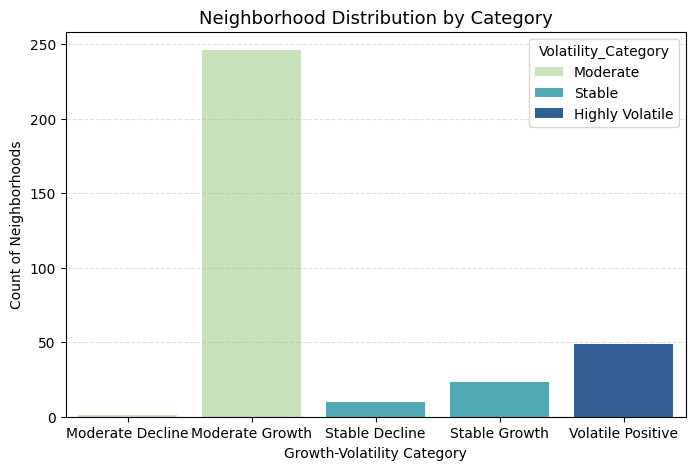

In [31]:
plt.figure(figsize=(8,5))
neighborhoods_categories=final_table.groupby(['Final_Category','Volatility_Category'])['neighborhood2'].count().reset_index()
sns.barplot(
    data=neighborhoods_categories,
    x='Final_Category',
    y='neighborhood2',
    hue='Volatility_Category',
    palette='YlGnBu'
)
plt.title('Neighborhood Distribution by Category', fontsize=13)
plt.xlabel('Growth-Volatility Category')
plt.ylabel('Count of Neighborhoods')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

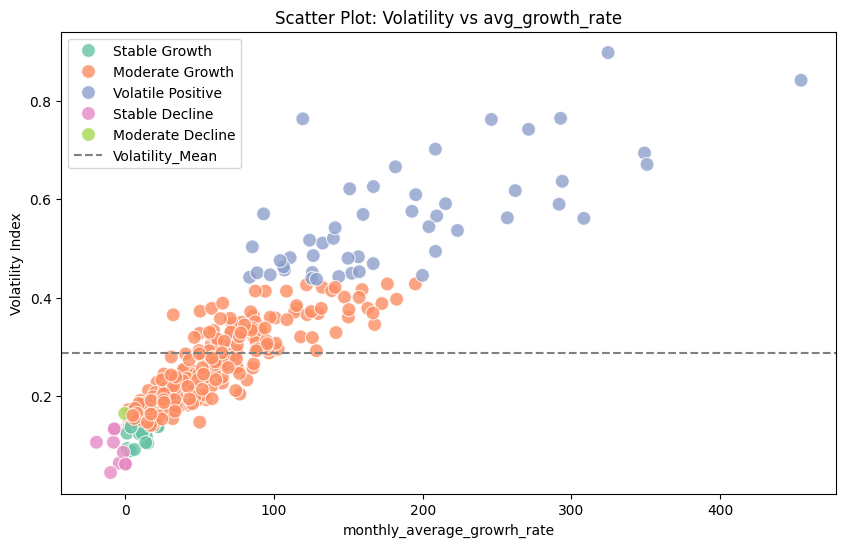

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
map={}
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=final_table, 
    x='monthly_avg_growth_rate', 
    y='Volatility', 
    hue='Final_Category', 
    palette='Set2',
    s=100,  
    alpha=0.8
)

plt.axhline(y=final_table['Volatility'].mean(), color='gray', linestyle='--', label='Volatility_Mean')
# plt.axvline(x=0, color='black', linestyle='-', label='روند خنثی')
plt.title('Scatter Plot: Volatility vs avg_growth_rate')
plt.xlabel('monthly_average_growrh_rate')
plt.ylabel('Volatility Index')
plt.legend()
plt.show()

# Mapped results on neighborhood polygons

In [128]:
gpd_merged = gdf.merge(final_table,on='neighborhood2', how='left')

In [129]:
gpd_merged.dropna(subset=['Final_Category'],inplace=True)

In [87]:
import folium

m = folium.Map(location=[35.7, 51.4], zoom_start=11)

category_colors = {
    "Stable Growth": "#1a9850",      
    "Moderate Growth": "#91cf60",       
    "Volatile Positive": "#ffd700",     
    "Moderate Decline": "#fc8d59",       
    "Stable Decline": "#d73027"      
}

for _, row in gpd_merged.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, category=row['Final_Category']: {
            'fillColor': category_colors.get(category, "gray"),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7
        },
        tooltip=folium.Tooltip(
            f"{row['neighborhood2']}<br>"
            f"Volatility: {row['Volatility']:.2f}<br>"
            f"Avg Growth: {row['monthly_avg_growth_rate']:.2f}<br>"
            f"Category: {row['Final_Category']}"
        )
    ).add_to(m)

m.save('tehran_neighborhoods.html')